## Custom written code for revision- striatum analysis

Run under the analysis2 environment

Figure 7 supplement 1 Innervation centers in caudoputamen

extracts axons in the caudoputamen (Allen atlas region id= 672), gaussian smooth, then get intensity profile in AP (ipsilateral only),DV (ipsilateral only) and ML axis from horizontal and coronal sum projections. Also outputs horizontal and coronal sum projections for each sample. 

No special instructions, simply run through all the code

In [2]:
import os

import pandas as pd

import numpy as np

#import Neuron_analysis as na

import skimage
from skimage import io
from skimage import filters
from skimage import segmentation
from skimage import measure

import re
from tqdm import tqdm

import nrrd

import matplotlib.pyplot as plt

In [3]:

def find_mousename(text):
    #finds name of mouse that follows the typical LSENS pattern: two letters followed by 3 numbers, ie AL000
    a= re.search('[a-zA-Z]{2}[0-9]{2,3}', text)
    return a[0]

def isolate_region_2(regions_list):
    
    '''useful for isolating one layer of multiple region, ie MOs 2/3 and MOp 2/3''' 
    
    #child_ids= atlas_labels.loc[atlas_labels['structure_id_path'].str.contains('|'.join(regions_list), case=False)].id
    # child_ids

    # find all regions with regionX inside the structure id path
    # for example 315 - isocortex, 985- primary motor region
    
    this_mask= np.zeros(annot_h.shape)
    # create empty array to store the mask
    for i in tqdm(regions_list):
        this_mask[annot_h==i]=1
        #loop through all the region id and assign value of 1
    # empty_array now is a matrix of 1 and 0s
    
    return this_mask

def conv_stereo(ML, AP, realum):
    '''input data points in terms of pixels and real pixel size in micrometers 
    calculates stereotaxic coordinate and return as ML, AP values'''
    bregma= [227.5, 215]
    # bregma coordiantes in horizontal view, where image dimension is [456, 528]
        
    tmpmedlat= abs(bregma[0]-ML)
    tmpantpos=bregma[1]- AP
    
    factor= realum/1000
    medlat=tmpmedlat*factor
    antpos= tmpantpos*factor
    # convert pixels to real micrometers
    
    return round(medlat,2), round(antpos,2)


In [4]:
working_directory= r'E:\CodeTest'
# this directory should contain folders Horizontal_Axon, ARA_25_micron_mhd_ccf2017, and file injection_sites_results_expanded

In [5]:
file_name = f'{working_directory}\ARA_25_micron_mhd_ccf2017\\annotation_25.nrrd'
data_array, metadata = nrrd.read(file_name)
# read atlas files

annot_h=np.moveaxis(data_array, 1, 0)
print('Converted to horizontal atlas with shape', annot_h.shape)
# reslice corontal atlas to horizontal atlas that is consistent with our sample's orientation

atlas_labels=pd.read_csv(f'{working_directory}\ARA_25_micron_mhd_ccf2017\labels.csv')
#read labels

Converted to horizontal atlas with shape (320, 528, 456)


In [6]:
# extract axons from striatum

region_id= [672]
#atlas id for MOp2/3, MOs2/3, MOp5, MOs5

# cannot be string to use isolate region2
region_mask= isolate_region_2(region_id)
# generate mask outside of the loop since it will be the same!

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.10it/s]


In [7]:
site='s1'

indir= f'{working_directory}\\Horizontal_Axon\\{site}\\npy'
outdir= f'{working_directory}\\CP_centroids\\{site}'
#os.makedirs(outdir)


files= os.listdir(indir)

In [9]:

# initialize numpy array to store values

datas1_DV=np.zeros((len(files),region_mask.shape[0]))
datas1_AP=np.zeros((len(files),region_mask.shape[1]))
datas1_ML=np.zeros((len(files),region_mask.shape[2]))
                     
# shape n files,then each of x,y,z dimension of atlas, which is nfile, DV, AP, ML axis


In [10]:
sample_list=[]

for count,i in enumerate(tqdm(files)): 
    
    file_path=os.path.join(indir,i)
    this_sample= find_mousename(i)
    # find the sample name
    
    axons=np.load(file_path)
    axons[0,0,0]=0
    axons[0,1,0]=0
    # load npy file and revert these two indices back to 0
    
    axons_masked= axons*region_mask
    
    # 0 for horizontal plane, 1 for coronal, 2 for saggital(need different adjustment)
    # create horizontal sum projection from the masked stack
    
    #axons_left= axons_masked[:,:,0:228] # take only striatum of the left side for finding max and getting contours
    axons_left= axons_masked
    
    axons_h_gaussian=skimage.filters.gaussian(axons_left.sum(0), sigma=4) # gaussian filter on horizontal section
    ML_axis= axons_h_gaussian.sum(0)
    
    axons_h_left_gaussian= skimage.filters.gaussian(axons_left[:,:,0:228].sum(0), sigma=4)
    AP_axis= axons_h_gaussian.sum(1)
    #ML_axis= np.divide(axons_h_gaussian.sum(0),left_mask_h.sum(0),where=left_mask_h.sum(0)!=0 )
    #AP_axis= np.divide(axons_h_gaussian.sum(1),left_mask_h.sum(1),where=left_mask_h.sum(1)!=0 )
    
    skimage.io.imsave(f'{outdir}\\{this_sample}_gaussian_h.tiff', axons_h_gaussian,check_contrast=False)

    
    axons_c_gaussian=skimage.filters.gaussian(axons_left.sum(1), sigma=4) # gaussian filter on coronal section
    DV_axis= axons_c_gaussian[:,0:228].sum(1)
    #DV_axis= np.divide(axons_c_gaussian.sum(1),left_mask_c.sum(1),where=left_mask_c.sum(1)!=0 )
    
    skimage.io.imsave(f'{outdir}\\{this_sample}_gaussian_c.tiff', axons_c_gaussian,check_contrast=False)

    
    datas1_DV[count,:]= DV_axis
    datas1_AP[count,:]= AP_axis
    datas1_ML[count,:]= ML_axis
    
    sample_list.append(this_sample)
    
    

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [01:33<00:00,  5.17s/it]


In [ ]:
# now plot each cre-lines separately


In [11]:
site='s2'

indir= f'{working_directory}\\Horizontal_Axon\\{site}\\npy'
outdir= f'{working_directory}\\CP_centroids\\{site}'
#os.makedirs(outdir)


files= os.listdir(indir)

In [12]:
# initialize numpy array to store values

datas2_DV=np.zeros((len(files),region_mask.shape[0]))
datas2_AP=np.zeros((len(files),region_mask.shape[1]))
datas2_ML=np.zeros((len(files),region_mask.shape[2]))
                     
# shape n files,then each of x,y,z dimension of atlas, which is nfile, DV, AP, ML axis

In [13]:
sample_list2=[]

for count,i in enumerate(tqdm(files)): 
    
    file_path=os.path.join(indir,i)
    this_sample= find_mousename(i)
    # find the sample name
    
    axons=np.load(file_path)
    axons[0,0,0]=0
    axons[0,1,0]=0
    # load npy file and revert these two indices back to 0
    
    axons_masked= axons*region_mask
    
    # 0 for horizontal plane, 1 for coronal, 2 for saggital(need different adjustment)
    # create horizontal sum projection from the masked stack
    
    #axons_left= axons_masked[:,:,0:228] # take only striatum of the left side for finding max and getting contours
    axons_left= axons_masked
    
    axons_h_gaussian=skimage.filters.gaussian(axons_left.sum(0), sigma=4) # gaussian filter on horizontal section
    ML_axis= axons_h_gaussian.sum(0)
    
    axons_h_left_gaussian= skimage.filters.gaussian(axons_left[:,:,0:228].sum(0), sigma=4)
    AP_axis= axons_h_left_gaussian.sum(1)
    #ML_axis= np.divide(axons_h_gaussian.sum(0),left_mask_h.sum(0),where=left_mask_h.sum(0)!=0 )
    #AP_axis= np.divide(axons_h_gaussian.sum(1),left_mask_h.sum(1),where=left_mask_h.sum(1)!=0 )
    
    skimage.io.imsave(f'{outdir}\\{this_sample}_gaussian_h.tiff', axons_h_gaussian,check_contrast=False)

    
    axons_c_gaussian=skimage.filters.gaussian(axons_left.sum(1), sigma=4) # gaussian filter on coronal section
    DV_axis= axons_c_gaussian[:,0:228].sum(1)
    #DV_axis= np.divide(axons_c_gaussian.sum(1),left_mask_c.sum(1),where=left_mask_c.sum(1)!=0 )
    skimage.io.imsave(f'{outdir}\\{this_sample}_gaussian_c.tiff', axons_c_gaussian,check_contrast=False)

    
    datas2_DV[count,:]= DV_axis
    datas2_AP[count,:]= AP_axis
    datas2_ML[count,:]= ML_axis
    
    sample_list2.append(this_sample)



100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [01:39<00:00,  5.25s/it]


In [24]:
# convert pixel to stereotaxis cordinate for AP and ML

bregma= [227.5, 215]
ML_stereo= (np.linspace(0,datas2_ML.shape[1]+1,datas2_ML.shape[1] )-bregma[0])* 25/1000
AP_stereo= (bregma[1]- np.linspace(0,datas2_AP.shape[1]+1,datas2_AP.shape[1] ))* 25/1000
DV_stereo= np.linspace(0,datas2_DV.shape[1],datas2_DV.shape[1] )* 25/1000
# convert pixel space to stereotaxic spaace

In [30]:
# now plot each cre-lines separately

# assign number for each cre line
# rasgrf 1, scnn 2, tlx3, sim4, rbp5, nts6
sample_creline= np.array([4,4,5,3,1,1,1,4,6,6,2,2,2,2,6,3,3,5])
samples2_creline= np.array([6,3,3,4,4,5,2,2,1,6,3,4,4,2,5,5,6,1,1])

Text(0.5, 0.98, 'DV')

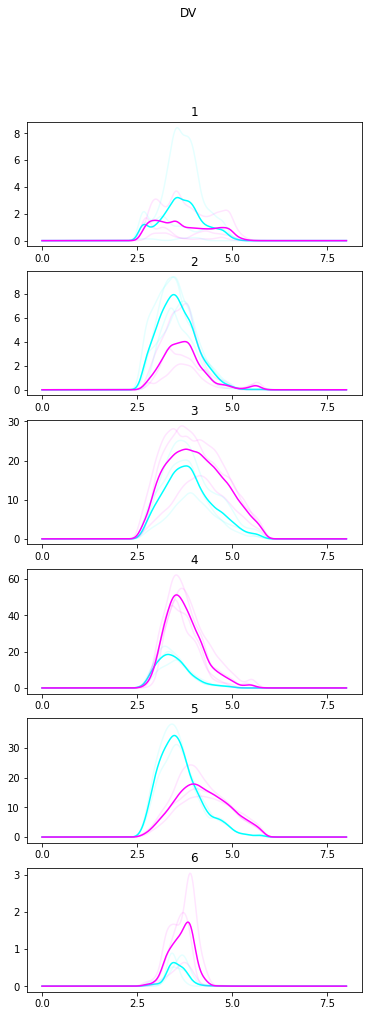

In [32]:
fig, axs = plt.subplots(6,1, figsize=(6,16))

for count, i in enumerate(range(1,7)):
    this_indexs1= np.argwhere(sample_creline==i)
    this_indexs2= np.argwhere(samples2_creline==i)
    
    this_s1= np.squeeze(datas1_DV[this_indexs1,:]).T
    this_s2= np.squeeze(datas2_DV[this_indexs2,:]).T
    
    axs[count].plot(DV_stereo,this_s1, color= 'cyan', alpha= 0.1)
    axs[count].plot(DV_stereo,np.mean(this_s1,1), color= 'cyan')
    axs[count].plot(DV_stereo,this_s2, color='magenta', alpha= 0.1)
    axs[count].plot(DV_stereo,np.mean(this_s2,1), color= 'magenta')
    
    #axs[count].set_ylim(0,60)
    axs[count].set_xticks([0,2.5,5,7.5])
    axs[count].set_title(f'{i}')

fig.suptitle('DV')

fig.savefig(working_directory+ "\CP_DV.svg")


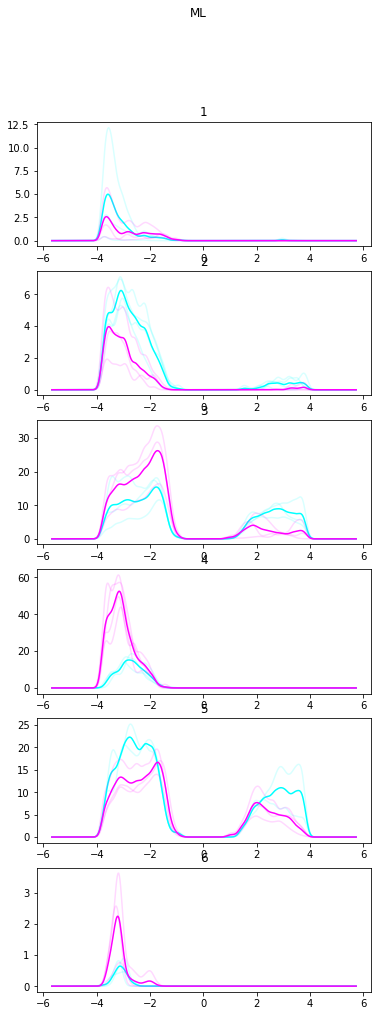

In [32]:
fig, axs = plt.subplots(6,1, figsize=(6,16))

for count, i in enumerate(range(1,7)):
    this_indexs1= np.argwhere(sample_creline==i)
    this_indexs2= np.argwhere(samples2_creline==i)
    
    this_s1= np.squeeze(datas1_ML[this_indexs1,:]).T
    this_s2= np.squeeze(datas2_ML[this_indexs2,:]).T
    
    axs[count].plot(ML_stereo, this_s1, color= 'cyan', alpha=0.15)
    axs[count].plot(ML_stereo,np.mean(this_s1,1), color= 'cyan')
    
    axs[count].plot(ML_stereo, this_s2, color='magenta', alpha=0.15)
    axs[count].plot(ML_stereo, np.mean(this_s2,1), color= 'magenta')
    
    #axs[count].set_ylim(0,60)
    #axs[count].set_yticks([0,20,40,60])
    axs[count].set_title(f'{i}')

fig.suptitle('ML')

fig.savefig(working_directory+ "\CP_M_bilat.svg")


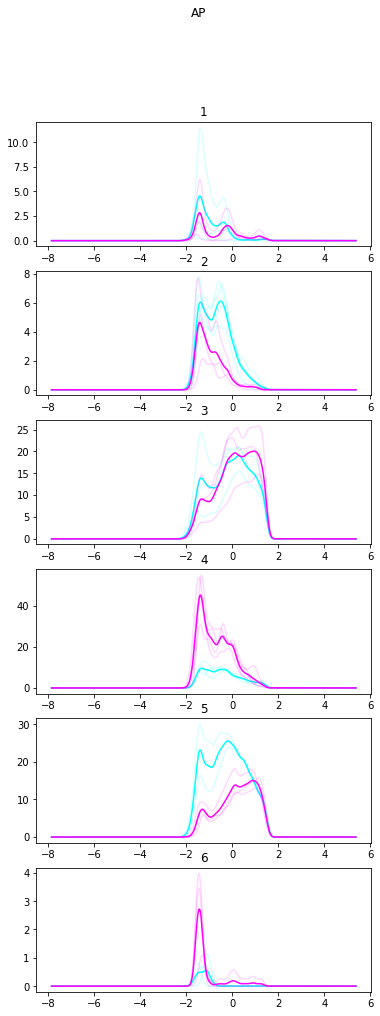

In [33]:
fig, axs = plt.subplots(6,1, figsize=(6,16))

for count, i in enumerate(range(1,7)):
    this_indexs1= np.argwhere(sample_creline==i)
    this_indexs2= np.argwhere(samples2_creline==i)
    
    this_s1= np.squeeze(datas1_AP[this_indexs1,:]).T
    this_s2= np.squeeze(datas2_AP[this_indexs2,:]).T
    
    axs[count].plot(AP_stereo, this_s1, color= 'cyan', alpha=0.15)
    axs[count].plot(AP_stereo,np.mean(this_s1,1), color= 'cyan')
    
    axs[count].plot(AP_stereo, this_s2, color='magenta', alpha=0.15)
    axs[count].plot(AP_stereo, np.mean(this_s2,1), color= 'magenta')
    
    #axs[count].set_ylim(0,60)
    #axs[count].set_yticks([0,20,40,60])
    axs[count].set_title(f'{i}')

fig.suptitle('AP')

fig.savefig(working_directory+ "\CP_AP.svg")


In [29]:
working_directory

'E:\\CodeTest'